In this notebook, I will experiment with making different maps to **visualise the menu healthiness of out-of-home food outlets** in Great Britain.

📖 A great online resource recommended by Tom: https://sites.google.com/umn.edu/mst/home
> "Choices have to be made about how to simplify the complexity of the world to be understandable on the map. Knowing who your audience is and having a clear sense of what you want to explain to them are crucial for deciding what to include and what to leave out."

The goal of this exercise is to generate two maps:
1. 🗺 Menu healthiness of online food outlets (JE)
2. 🗺 Menu healthiness of all food outlets (OS)



Questions for discussion:

1. Should we focus on visualising the menu healthiness of all out of home food outlets, or present both **the menu healthiness of physical outlets** and **the menu healthiness of online food outlets**?

2. Should we present the menu healthiness on the LSOA level, LA level, or other levels?

3. Should the scope of the map be England or the GB?

4. Which metric to use. e.g., average menu healthiness?

Map related questions:

1. How to deal with missing values?



# Mapping menu healthiness of online food outlets

In [ ]:
import pandas as pd

je_summary = pd.read_csv('/content/je_predicted_matchedLSOA.csv')
je_summary.head()

,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,rest_name,address,...,oac11,lat,long,lep1,lep2,pfa,imd,calncv,stp,rating
0,80603,0,5,2,11,1,0,5,Pasha Kebabs & Pizzas,"25 Windmill Brae, Aberdeen, AB11 6HU",...,2B1,57.144885,-2.102373,S99999999,S99999999,S23000009,3228,S99999999,S99999999,1
1,71703,10,10,2,14,1,0,4,Paco's Tacos,"42-44 Market Street, Aberdeenshire, AB11 5PL",...,2B1,57.146069,-2.096881,S99999999,S99999999,S23000009,3265,S99999999,S99999999,0
2,6885,0,17,12,1,0,0,2,Dil Se,"Unit 8, The Green Berrymuir Road, Portlethen, ...",...,6A3,57.056581,-2.140509,S99999999,S99999999,S23000009,5955,S99999999,S99999999,4
3,122605,7,10,6,44,0,0,1,Mannofield Pizza Grill and Kebab,"483a Great Western Road, Aberdeen, AB10 6NN",...,5B2,57.132002,-2.135351,S99999999,S99999999,S23000009,6786,S99999999,S99999999,1
4,44832,0,17,2,1,0,0,2,Lasan Healthy Indian Brasserie,"Unit 2 Westhill Drive, Westhill, Aberdeenshire...",...,6B3,57.152738,-2.274791,S99999999,S99999999,S23000009,6635,S99999999,S99999999,3


## LSOA level

Boundaries: https://geoportal.statistics.gov.uk (only found boundaries for England and Wales)


> "Statistics for lower layer super output areas (LSOA) and middle layer super output areas (MSOA) were originally released in 2004 for England and Wales. Scotland also released statistics for data zones (DZ), that were equivalent to LSOAs, in 2004 and intermediate geographies (IG), that were equivalent to MSOAs, in 2005. Northern Ireland introduced LSOAs in 2005 but do not have an MSOA geography."



In [ ]:
#!pip install geopandas
import geopandas as gpd
lsoa_imd = gpd.read_file('https://opendata.arcgis.com/datasets/4ad3e5a10872455eaa67ce4e663d0d01_0.geojson')

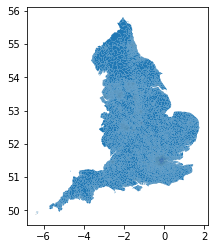

In [ ]:
lsoa_imd.plot() # boundaries

summarise menu healthiness (online food outlets) at the LSOA level

In [ ]:
# group menu healthiness (online) at the LSOA level
import numpy as np
online_lsoa_summary = je_summary.groupby('lsoa11').agg(total_n = ("Restaurant ID", len),
                                             average_healthiness=('predict','mean'),
                                             median_healthiness = ('predict','median'),
                                             over_0 = ('rating2',lambda x: (x > 0).sum()),
                                             over_1 = ('rating2',lambda x: (x > 1).sum()),
                                             over_2 = ('rating2',lambda x: (x > 2).sum()),
                                             over_3 = ('rating2',lambda x: (x > 2).sum()),
                                             IMD = ('imd','mean') #IMD scores should be the same
                                             )
online_lsoa_summary.head()

,total_n,average_healthiness,median_healthiness,over_0,over_1,over_2,over_3,IMD
lsoa11,,,,,,,,
95AA01S3,1,6.494730,6.494730,1,0,0,0,658.0
95AA11S1,5,6.784341,6.897691,4,3,1,1,670.0
95AA13S2,1,6.108902,6.108902,1,0,0,0,676.0
95BB01S2,1,7.011913,7.011913,1,1,0,0,701.0
95BB04S1,1,6.869371,6.869371,1,1,0,0,467.0


In [ ]:
# create deciles
online_lsoa_summary['Menu Healthiness Deciles'] = pd.qcut(online_lsoa_summary['average_healthiness'], 10,
                               labels = False)

In [ ]:
online_lsoa_shape = lsoa_imd.merge(online_lsoa_summary, how='left',right_on='lsoa11',left_on='lsoa11cd')

In [ ]:
# how many lsoas with online delivery services
print(str(sum(online_lsoa_shape.total_n.isnull())) + ' lsoas do not have online delivery services')
print(f'Among a total of {online_lsoa_shape.shape[0]} lsoas in England')

20279 lsoas do not have online delivery services
Among a total of 32844 lsoas in England


In [ ]:
(32844-20279)/32844

0.3825660699062234

### Map 1: crude (no design), use average healthiness as a continous variable

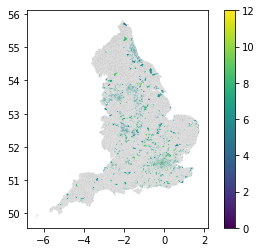

In [ ]:
online_lsoa_shape.plot('average_healthiness', legend=True, missing_kwds={'color': 'lightgrey'})

### Map 2: the same color, use average menu healthiness as a continous variable

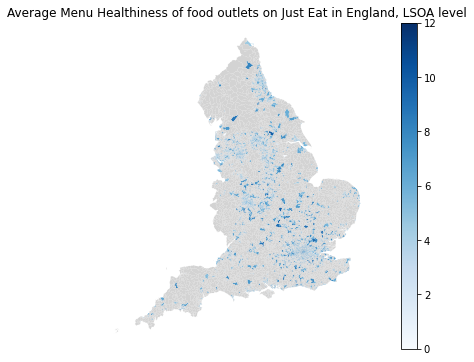

In [ ]:
import matplotlib.pyplot as plt

def create_map(col_name, dat, title, cmap='Blues'):
  fig, ax = plt.subplots(1, figsize=(10, 6))
  dat.plot(column=col_name, ax=ax, cmap=cmap,missing_kwds={'color': 'lightgrey'})
  ax.axis('off')
  vmin = dat[col_name].min()
  vmax = dat[col_name].max()
  # Create colorbar
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
  sm._A = []
  cbar = fig.colorbar(sm)
  plt.title(title)

create_map(col_name='average_healthiness',dat =online_lsoa_shape, title='Average Menu Healthiness of food outlets on Just Eat in England, LSOA level')

### Map 3: the same color, use menu healthiness deciles

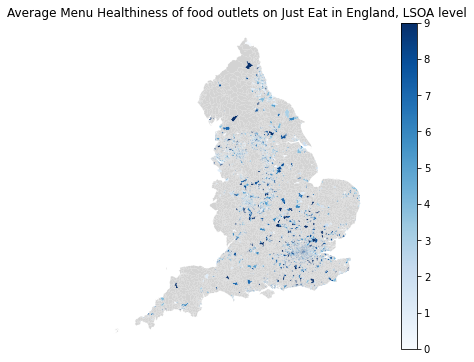

In [ ]:
create_map(col_name='Menu Healthiness Deciles',dat =online_lsoa_shape, title='Average Menu Healthiness of food outlets on Just Eat in England, LSOA level')


🔑 The problem with plotting menu healthiness of online food outlets lies in that most lsoas do not have online delivery services available (majority missing)



>**Conclusion: not suitable to plot average menu healthiness of online food outlets on the LSOA level across England**



### Map 4: selected cities, the same color, use menu healthiness deciles

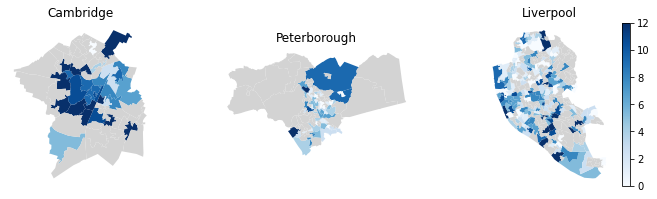

In [ ]:
# now plot Cambridge, Liverpool, and Peterborough
fig, ax = plt.subplots(1,3, figsize=(12, 3),subplot_kw=dict(aspect='equal'))
vmin = online_lsoa_shape['average_healthiness'].min()
vmax = online_lsoa_shape['average_healthiness'].max()
areas = ['Cambridge','Peterborough','Liverpool']
# for each panel in the plot
for i, ax_ in enumerate(ax):
  dat_forplot = online_lsoa_shape[online_lsoa_shape['LADnm']==areas[i]]
  dat_forplot.plot(column='Menu Healthiness Deciles', ax=ax_, cmap='Blues',missing_kwds={'color': 'lightgrey'})
  ax_.axis('off')
  ax_.set_title(areas[i])
# Create colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

## Local authority district level

local authority district level boundaries for the GB

In [ ]:
#!pip install geopandas
#import geopandas as gpd
la_b= gpd.read_file('https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Local_Authority_Districts_December_2021_GB_BGC/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.0 MB/s 
     |████████████████████████████████| 6.3 MB 41.1 MB/s 
     |████████████████████████████████| 16.7 MB 392 kB/s 


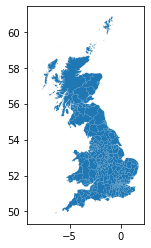

In [ ]:
la_b.plot()

In [ ]:
online_la_summary = je_summary.groupby('laua').agg(average_healthiness=('predict','mean'),
                                                   median_healthiness = ('predict','median'),
                                                   total_n = ('Restaurant ID',len),
                                             over_0 = ('rating2',lambda x: (x > 0).sum()),
                                             over_1 = ('rating2',lambda x: (x > 1).sum()),
                                             over_2 = ('rating2',lambda x: (x > 2).sum()),
                                             over_3 = ('rating2',lambda x: (x > 2).sum())                                             )
online_la_summary.head()
online_la_summary

,average_healthiness,median_healthiness,total_n,over_0,over_1,over_2,over_3
laua,,,,,,,
E06000001,5.937717,5.905264,109,76,29,5,5
E06000002,5.875407,5.822854,165,104,52,12,12
E06000003,5.851892,5.623061,80,55,18,7,7
E06000004,5.843464,5.947989,158,108,51,4,4
E06000005,6.117268,5.948108,95,63,29,12,12
...,...,...,...,...,...,...,...
W06000020,5.953609,5.668148,43,25,13,2,2
W06000021,7.424242,7.113238,15,14,12,6,6
W06000022,6.223866,6.428216,159,111,74,15,15


In [ ]:
online_la_summary['over_0_percent'] = online_la_summary['over_0']/online_la_summary['total_n']
online_la_summary['over_1_percent'] = online_la_summary['over_1']/online_la_summary['total_n']
online_la_summary['over_2_percent'] = online_la_summary['over_2']/online_la_summary['total_n']
online_la_summary['over_3_percent'] = online_la_summary['over_3']/online_la_summary['total_n']

In [ ]:
online_la_shape = la_b.merge(online_la_summary, how='left',right_on='laua',left_on='LAD21CD')

### Map 5: the same color, use average menu healthiness on the local authority level as a continous variable

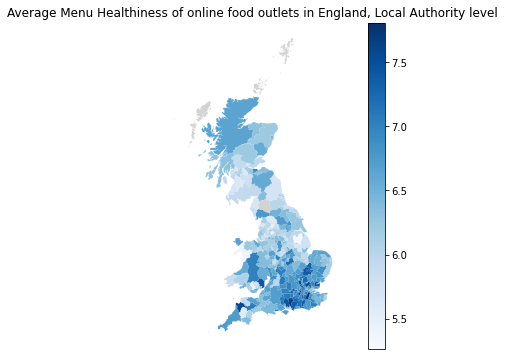

In [ ]:
# absolute healthiness - all quite close
create_map(col_name='average_healthiness',dat =online_la_shape, title='Average Menu Healthiness of online food outlets in England, Local Authority level')

### Map 6: the same color, use menu healthiness deciles on the local authority level

In [ ]:
# deciles of rannking
online_la_shape['Menu Healthiness Deciles'] = pd.qcut(online_la_shape['average_healthiness'], 10,
                                              labels =['Q1 (the least healthy)','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10 (the most healthy)'])

In [ ]:
#!pip install mapclassify

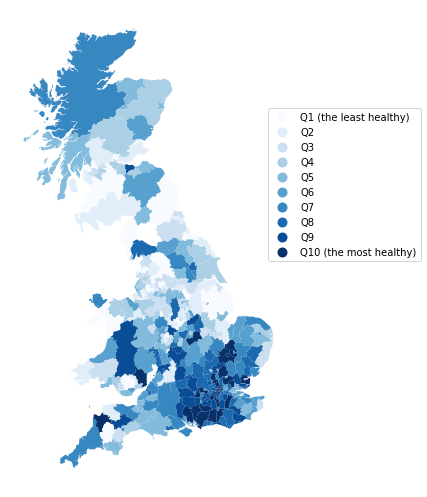

In [ ]:
ax=online_la_shape.plot(column='Menu Healthiness Deciles', figsize=(5,10),
             cmap='Blues', legend=True, legend_kwds={'bbox_to_anchor': (1.5, 0.8)})
ax.set_axis_off()

### Map 7: Bupu color scale, use menu healthiness deciles on the local authority level

https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html

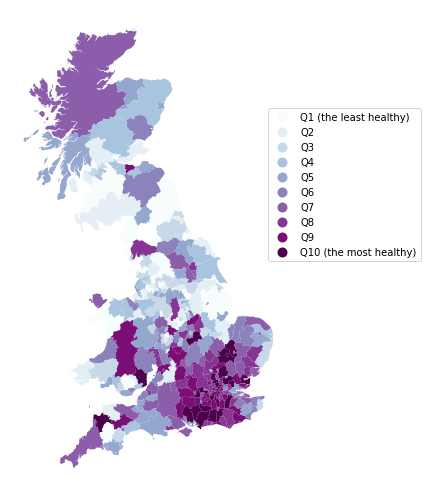

In [ ]:
ax=online_la_shape.plot(column='Menu Healthiness Deciles', figsize=(5,10),
             cmap='BuPu', legend=True, legend_kwds={'bbox_to_anchor': (1.5, 0.8)})
ax.set_axis_off()

### Map 8: Bupu color scale, use proportion of online food outlets with a rating > 2

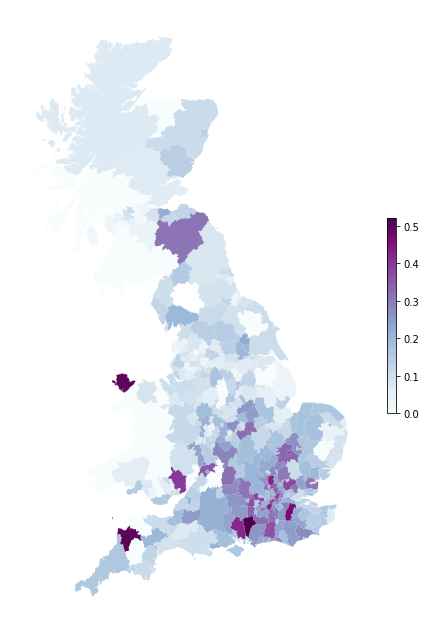

In [ ]:
ax=online_la_shape.plot(column='over_2_percent', figsize=(8,12),
             cmap='BuPu', legend=True,legend_kwds={'shrink': 0.3})
ax.set_axis_off()

Conclusion: BuPu color scale on LA level looks good. Either using menu healthiness deciles or proportion online food outlets with a menu healthiness rating >2 yield similar patterns.

# Mapping the menu healthiness of all food outlets

In [ ]:
# import pandas as pd
poi = pd.read_csv('/content/POI_predicted_matchedLSOA.csv')
poi.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,...1,ref_no,name,pointx_class,feature_easting,feature_northing,pos_accuracy,uprn,topo_toid,topo_toid_version,...,oac11,lat,long,lep1,lep2,pfa,imd,calncv,stp,rating
0,1,18857205.0,Welcome Break (Charnock Richard),1020043,354292.7,415048.2,1,1.112586e-308,osgb1000037990682,8,...,1B1,53.631499,-2.690751,E37000019,NaN,E23000003,22291,E56000018,E54000048,2
1,2,20078819.0,Welcome Break (Hartshead Moor),1020043,416830.0,424112.0,1,0.000000e+00,osgb1000031997248,5,...,1B1,53.714327,-1.746460,E37000062,NaN,E23000010,20304,E56000030,E54000054,2
2,3,18857213.0,Welcome Break (Leicester Forest East),1020043,453839.0,302654.0,1,1.112539e-308,osgb5000005161729586,1,...,6B1,52.619002,-1.206122,E37000021,NaN,E23000021,23065,E56000024,E54000015,2
3,4,18857223.0,Welcome Break (Warwick Northbound),1020043,433887.1,257699.7,1,1.112562e-308,osgb1000017044508,11,...,1A3,52.219853,-1.515881,E37000006,NaN,E23000017,16796,E56000007,E54000018,2
4,5,18857202.0,Welcome Break (Abington),1020043,292990.0,625056.0,1,1.112537e-308,osgb1000036194809,14,...,1A3,55.507502,-3.695989,S99999999,S99999999,S23000009,1908,S99999999,S99999999,2


In [ ]:
import numpy as np
lsoa_summary = poi.groupby('lsoa11').agg(total_n = ("ref_no", len),
                                             average_healthiness=('predicted_score','mean'),
                                             median_healthiness = ('predicted_score','median'),
                                             over_0 = ('rating',lambda x: (x > 0).sum()),
                                             over_1 = ('rating',lambda x: (x > 1).sum()),
                                             over_2 = ('rating',lambda x: (x > 2).sum()),
                                             over_3 = ('rating',lambda x: (x > 2).sum()),
                                             IMD = ('imd','mean') #IMD scores should be the same
                                             )
lsoa_summary.head()

,total_n,average_healthiness,median_healthiness,over_0,over_1,over_2,over_3,IMD
lsoa11,,,,,,,,
E01000001,22,7.668697,7.095682,22,17,4,4,29199.0
E01000002,38,7.490187,7.018792,38,26,6,6,30379.0
E01000003,4,7.184360,7.229410,4,3,0,0,14915.0
E01000005,89,7.515362,7.037163,89,74,15,15,8678.0
E01000007,10,6.545637,6.618419,10,5,0,0,7256.0


In [ ]:
lsoa_summary['over_0_percent'] = lsoa_summary['over_0']/lsoa_summary['total_n']
lsoa_summary['over_1_percent'] = lsoa_summary['over_1']/lsoa_summary['total_n']
lsoa_summary['over_2_percent'] = lsoa_summary['over_2']/lsoa_summary['total_n']
lsoa_summary['over_3_percent'] = lsoa_summary['over_3']/lsoa_summary['total_n']

In [ ]:
# create deciles
lsoa_summary['Menu Healthiness Deciles'] = pd.qcut(lsoa_summary['average_healthiness'], 10,
                               labels = None)

In [ ]:
# create quintiles
lsoa_summary['Menu Healthiness Quintiles'] = pd.qcut(lsoa_summary['average_healthiness'], 5,
                               labels = None)

In [ ]:
lsoa_imd_shape = lsoa_imd.merge(lsoa_summary, how='left',right_on='lsoa11',left_on='lsoa11cd')

## LSOA level

### Map 8: Blues, use the average menu healthiness on the local authority level as a continous variable

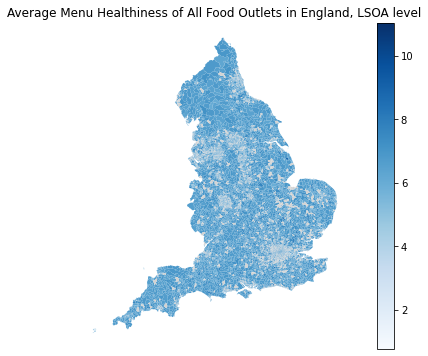

In [ ]:
create_map(col_name='average_healthiness',dat =lsoa_imd_shape, title='Average Menu Healthiness of All Food Outlets in England, LSOA level')

### Map 9: Blues, use the menu healthiness Deciles on the local authority level as a continous variable

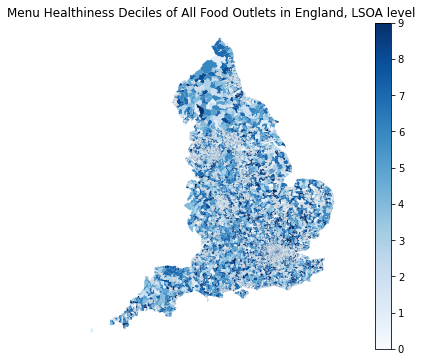

In [ ]:
create_map(col_name='Menu Healthiness Deciles',dat =lsoa_imd_shape, title='Menu Healthiness Deciles of All Food Outlets in England, LSOA level')

### Map 10: BuPu, use the menu healthiness Deciles on the local authority level as a continous variable

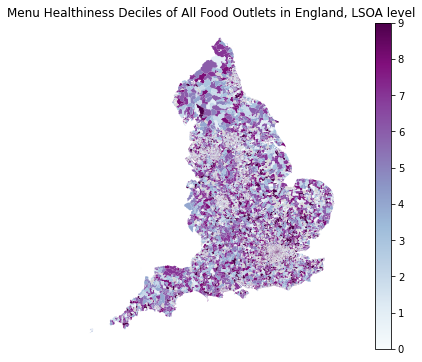

In [ ]:
create_map(col_name='Menu Healthiness Deciles',dat =lsoa_imd_shape, cmap='BuPu', title='Menu Healthiness Deciles of All Food Outlets in England, LSOA level')

conclusion: LSOA is too granular -> difficult to identify patterns

## LA level

In [ ]:
la_summary = poi.groupby('laua').agg(average_healthiness=('predicted_score','mean'))
la_menu = la_b.merge(la_summary, how='left',right_on='laua',left_on='LAD21CD')

### Map 11: Blues, use the average menu healthiness score on the LA level

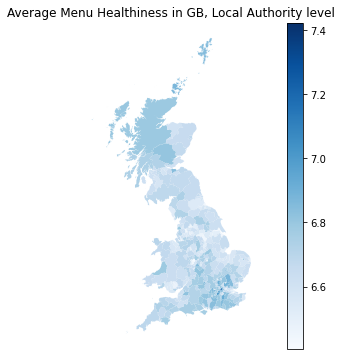

In [ ]:
create_map(col_name='average_healthiness',dat =la_menu, title='Average Menu Healthiness in GB, Local Authority level')

### Map 12: Blues, use the menu healthiness deciles on LA level

In [ ]:
# deciles of rannking
la_menu['Menu Healthiness Deciles'] = pd.qcut(la_menu['average_healthiness'], 10,
                                              labels =['Q1 (the least healthy)','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10 (the most healthy)'])

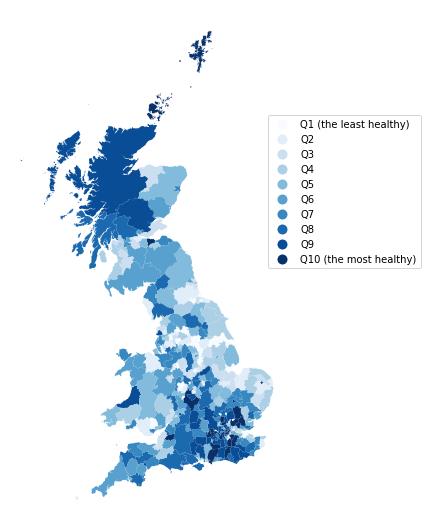

In [ ]:
ax=la_menu.plot(column='Menu Healthiness Deciles', figsize=(5,10),
             cmap='Blues', legend=True, legend_kwds={'bbox_to_anchor': (1.5, 0.8)})
ax.set_axis_off()

### Map 13: BuPu, use the menu healthiness deciles on LA level

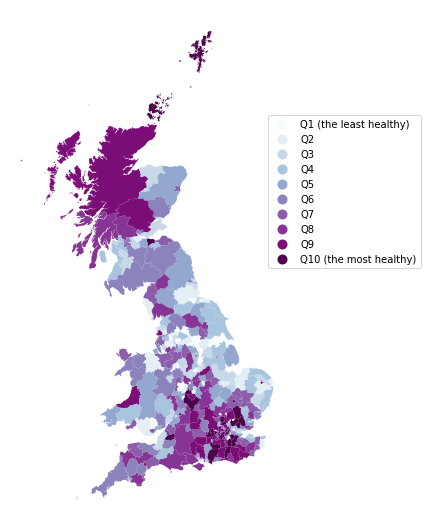

In [ ]:
ax=la_menu.plot(column='Menu Healthiness Deciles', figsize=(5,10),
             cmap='BuPu', legend=True, legend_kwds={'bbox_to_anchor': (1.5, 0.8)})
ax.set_axis_off()

# Combined Map of Online and All Physical Food Outlets

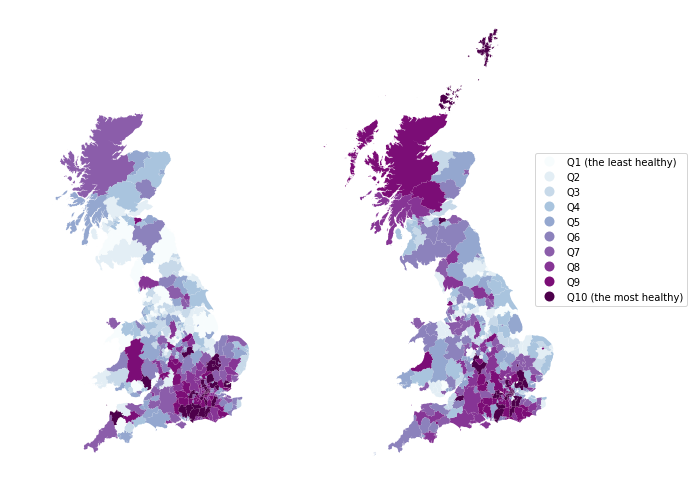

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,20), sharey=True, sharex=True)
fig1 = online_la_shape.plot(column='Menu Healthiness Deciles', ax=axs[0],
             cmap='BuPu')
axs[0].set_axis_off()
la_menu.plot(column='Menu Healthiness Deciles',ax=axs[1],
             cmap='BuPu',legend=True,legend_kwds={'bbox_to_anchor': (1.5, 0.7)})
axs[1].set_axis_off()

# The final map of to focus:
 The menu healthiness of all (physical) food outlets

In [ ]:
la_menu['Menu Healthiness Quintiles'] = pd.qcut(la_menu['average_healthiness'], 5, labels = ['Q1: 6.40-6.58',
                                                                                             'Q2: 6.58-6.64',
                                                                                             'Q3: 6.64-6.69',
                                                                                             'Q4: 6.69-6.77',
                                                                                             'Q5: 6.77-7.42'])


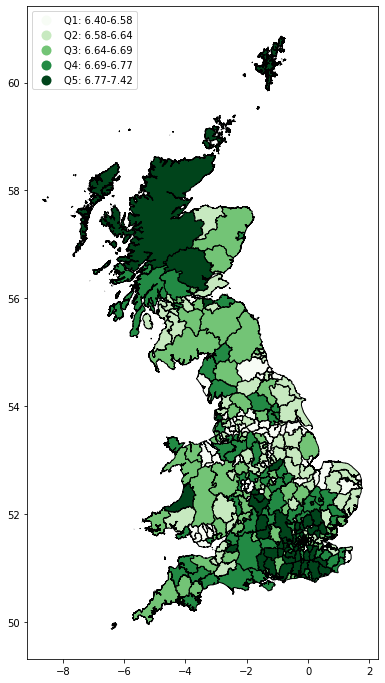

In [ ]:
la_menu.plot(column='Menu Healthiness Quintiles', figsize=(8,12),
             cmap='Greens', legend=True,legend_kwds={'loc': 'upper left'},edgecolor='black')
plt.savefig('LA_all_green.png',dpi=300,bbox_inches='tight')


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

red_reversed = matplotlib.cm.get_cmap('Reds_r')

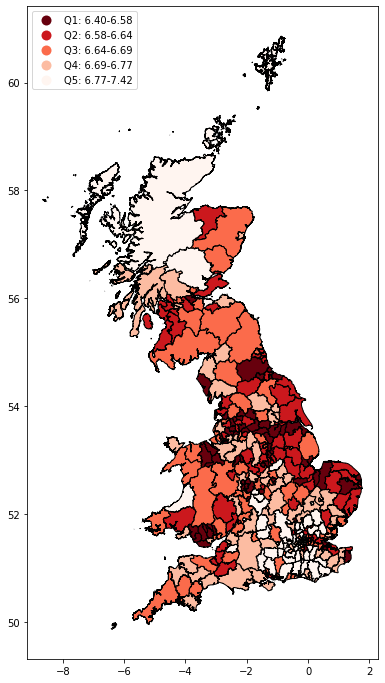

In [ ]:
la_menu.plot(column='Menu Healthiness Quintiles', figsize=(8,12),
             cmap=red_reversed, legend=True,legend_kwds={'loc': 'upper left'},edgecolor='black')
plt.savefig('LA_all_je.png',dpi=300,bbox_inches='tight')